### Explore surface Argo oxygen float and World Ocean Atlas data
*Get cached surface data and compare with data from the World Ocean Atlas*

Build local cache of data from floats known to have oxygen data:

```bash
scripts/load_cache.py --wmo 1900650 1901157 5901073 -v
```

Add parent directory to the path and get an ArgoData object that uses the local cache file built with above command.

In [1]:
import sys
sys.path.insert(0, '../')

from biofloat import ArgoData
ad = ArgoData(cache_file='../biofloat/biofloat_fixed_cache_wmo1900650-1901157-5901073.hdf')

Get a Pandas DataFrame of all the data in this cache file.

In [2]:
%%time
wmo_list = ['1900650', '1901157', '5901073']
ad.set_verbosity(0)
df = ad.get_float_dataframe(wmo_list)

CPU times: user 33 s, sys: 1.69 s, total: 34.6 s
Wall time: 47.2 s


Define a function to make a map.

In [3]:
%pylab inline
import pylab as plt
from mpl_toolkits.basemap import Basemap

def map(lons, lats):
    m = Basemap(llcrnrlon=15, llcrnrlat=-90, urcrnrlon=390, urcrnrlat=90, projection='cyl')
    m.fillcontinents(color='0.8')
    m.scatter(lons, lats, latlon=True, color='red')

Populating the interactive namespace from numpy and matplotlib


See where these floats have been.

/home/mccann/VirtualEnvs/biofloat/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


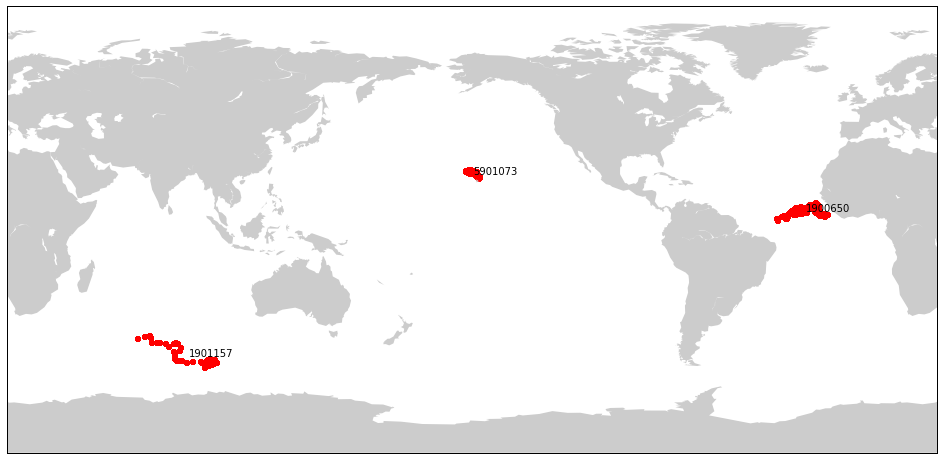

In [4]:
plt.rcParams['figure.figsize'] = (18.0, 8.0)
tdf = df.copy()
tdf['lon'] = tdf.index.get_level_values('lon')
tdf['lat'] = tdf.index.get_level_values('lat')
map(tdf.lon, tdf.lat)

for wmo, lon, lat in tdf.groupby(level='wmo')['lon', 'lat'].mean().itertuples():
    if lon < 0:
        lon += 360
    plt.text(lon, lat, wmo)

In [5]:
tdf = df.copy()
tdf['lon'] = tdf.index.get_level_values('lon')
tdf['lat'] = tdf.index.get_level_values('lat')
tdf.groupby(level='wmo')['lon', 'lat'].mean()

,lon,lat
wmo,,
1900650,-22.655823,7.252262
1901157,88.794916,-51.104705
5901073,-156.711130,22.508588


Collapse the surface values into a single value with a `.mean()` (can try doing a `.median()`).

In [7]:
import pandas as pd
sdf = df.query('(pressure < 10)').groupby(level=['wmo', 'time', 'lon', 'lat']).median()
sdf.head()

DOXY_ADJUSTED  \
wmo     time                       lon     lat                    
1900650 2006-06-21 00:53:00.038400 -34.276 3.892     205.699997   
        2006-07-01 00:22:59.980800 -34.346 3.564     206.080002   
        2006-07-11 00:13:00.019200 -34.668 4.255     206.910004   
        2006-07-21 01:03:00.000000 -32.430 4.901     208.699997   
        2006-07-31 00:33:59.990400 -31.891 5.599     207.869995   

                                                  PSAL_ADJUSTED  TEMP_ADJUSTED  
wmo     time                       lon     lat                                  
1900650 2006-06-21 00:53:00.038400 -34.276 3.892      35.855995      28.360001  
        2006-07-01 00:22:59.980800 -34.346 3.564      35.701042      28.250999  
        2006-07-11 00:13:00.019200 -34.668 4.255      35.522896      28.028999  
        2006-07-21 01:03:00.000000 -32.430 4.901      35.427776      28.358999  
        2006-07-31 00:33:59.990400 -31.891 5.599      35.600708      28.209999

Before computing monthly means let's add lat, lon, wmo, and month and year numbers to the DataFrame.

In [8]:
sdf['lon'] = sdf.index.get_level_values('lon')
sdf['lat'] = sdf.index.get_level_values('lat')
sdf['month'] = sdf.index.get_level_values('time').month
sdf['year'] = sdf.index.get_level_values('time').year
sdf['wmo'] = sdf.index.get_level_values('wmo')

Compute the monthly means and add percent saturation column using the Gibbs SeaWater Oceanographic Package of TEOS-10.

In [9]:
msdf = sdf.groupby(['wmo', 'year', 'month']).mean()

from biofloat.utils import o2sat, convert_to_mll
msdf['o2sat'] = 100 * (msdf.DOXY_ADJUSTED / o2sat(msdf.PSAL_ADJUSTED, msdf.TEMP_ADJUSTED))
msdf.head(10)

DOXY_ADJUSTED  PSAL_ADJUSTED  TEMP_ADJUSTED        lon  \
wmo     year month                                                           
1900650 2006 6         205.699997      35.855995      28.360001 -34.276000   
             7         207.389999      35.563106      28.212249 -33.333750   
             8         208.149999      35.025506      28.059667 -31.027000   
             9         207.633334      34.861734      28.275334 -30.321667   
             10        207.956665      34.432004      28.738667 -28.316667   
             11        207.790003      35.208557      28.449000 -26.357667   
             12        209.139999      35.491273      27.755000 -25.575333   
        2007 1         209.983337      35.559322      27.296667 -26.867000   
             2         211.626668      35.678707      26.832000 -28.320000   
             3         212.133336      35.816099      26.725667 -28.167333   

                         lat       o2sat  
wmo     year month                        
1900650 2006 6      3.892000  105.913869  
             7      4.579750  106.336813  
             8      4.595000  106.106463  
             9      5.486667  106.098942  
             10     6.555333  106.761580  
             11     6.368000  106.705865  
             12     6.333000  106.404126  
        2007 1      6.146000  106.092792  
             2      6.723333  106.200515  
             3      7.562667  106.363446

Add columns `ilon` & `ilat` ('i', for index) rounding lat and lon to nearest 0.5 degree mark to facilitate lookups from the World Ocean Atlas. 

In [10]:
def round_to(n, increment, mark):
    correction = mark if n >= 0 else -mark
    return int( n / increment) + correction

imsdf = msdf.copy()
imsdf['ilon'] = msdf.apply(lambda x: round_to(x.lon, 1, 0.5), axis=1)
imsdf['ilat'] = msdf.apply(lambda x: round_to(x.lat, 1, 0.5), axis=1)
imsdf.head()

DOXY_ADJUSTED  PSAL_ADJUSTED  TEMP_ADJUSTED        lon  \
wmo     year month                                                           
1900650 2006 6         205.699997      35.855995      28.360001 -34.276000   
             7         207.389999      35.563106      28.212249 -33.333750   
             8         208.149999      35.025506      28.059667 -31.027000   
             9         207.633334      34.861734      28.275334 -30.321667   
             10        207.956665      34.432004      28.738667 -28.316667   

                         lat       o2sat  ilon  ilat  
wmo     year month                                    
1900650 2006 6      3.892000  105.913869 -34.5   3.5  
             7      4.579750  106.336813 -33.5   4.5  
             8      4.595000  106.106463 -31.5   4.5  
             9      5.486667  106.098942 -30.5   5.5  
             10     6.555333  106.761580 -28.5   6.5

Build a dictionary (`woa`) of OpenDAP monthly URLs to the o2sat data.

In [11]:
woa_tmpl = 'http://data.nodc.noaa.gov/thredds/dodsC/woa/WOA13/DATA/o2sat/netcdf/all/1.00/woa13_all_O{:02d}_01.nc'
woa = {}
for m in range(1,13):
    woa[m] = woa_tmpl.format(m)

Define a function to get WOA `O_an` (Objectively analyzed mean fields for fractional_saturation_of_oxygen_in_seawater at standard depth) variable given a month, depth, latitude, and longitude.

In [12]:
import xray
def woa_o2sat(month, depth, lon, lat):
    ds = xray.open_dataset(woa[month], decode_times=False)
    return ds.loc[dict(lon=lon, lat=lat, depth=depth)]['O_an'].values[0]

Add the `woa_o2sat` column, taken from 5.0 m depth for each month and position of the float.

In [13]:
%%time
woadf = imsdf.copy()
woadf['month'] = woadf.index.get_level_values('month')
woadf['woa_o2sat'] = woadf.apply(lambda x: woa_o2sat(x.month, 5.0, x.ilon, x.ilat), axis=1)

CPU times: user 2.32 s, sys: 360 ms, total: 2.68 s
Wall time: 1min 32s


The above takes a few minutes to do the WOA lookups, so let's copy the 'o2...' columns of the result to a DataFrame that we'll use for calculating the gain over time for each float. Add `wmo` column back and make a Python datetime index.

In [14]:
gdf = woadf[['o2sat', 'woa_o2sat']].copy()
gdf['wmo'] = gdf.index.get_level_values('wmo')
years = gdf.index.get_level_values('year')
months = gdf.index.get_level_values('month')
gdf['date'] = pd.to_datetime(years * 100 + months, format='%Y%m')

Plot the gain over time for each of the floats.

/home/mccann/VirtualEnvs/biofloat/lib/python2.7/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


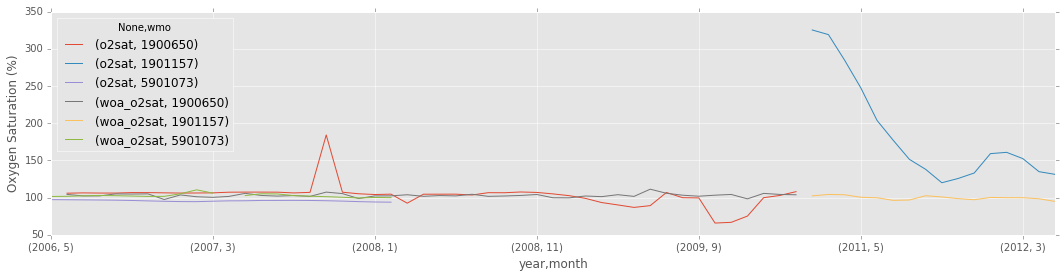

In [15]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18.0, 4.0)
ax = gdf[['o2sat', 'woa_o2sat']].unstack(level=0).plot()
ax.set_ylabel('Oxygen Saturation (%)')

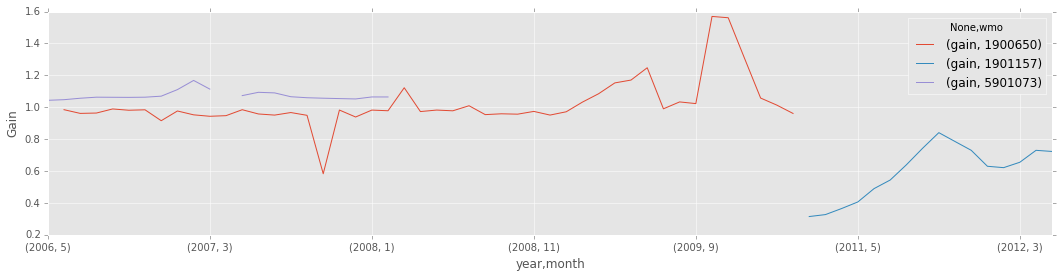

In [16]:
gdf['gain'] = gdf.woa_o2sat / gdf.o2sat
ax = gdf[['gain']].unstack(level=0).plot()
ax.set_ylabel('Gain')

Print the mean gain value for each float. Values much less than 1 should not be trusted (Josh Plant, personal communication).

In [17]:
gdf.groupby('wmo').gain.mean()

wmo
1900650    1.019835
1901157    0.596373
5901073    1.073153
Name: gain, dtype: float64